# fast.torch
This should be a template for training self-supervised models using PyTorch and fastai. 

In [2]:
## imports and helper functions. jump to config

import sys
sys.path.append('../')
sys.path.append('../../../model')
from losses import *
from data import EMSelfPlay
from utils import *
from enum import Enum
from model import DynamicUnet
from custom_transforms import RandomCutOut, ToGrayScale

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from fastprogress.fastprogress import master_bar, progress_bar

def get_lrs(dataloader, max_lr=1e-3, min_lr=None, max_mom=0.95):
    """This function returns arrays for learning rates and momentum
    following the One Cycle Policy"""
    num_batches = len(dataloader)
    if not min_lr: min_lr = max_lr/10
    lrs_up = np.linspace(min_lr, max_lr, num_batches // 2)
    lrs_down = np.linspace(max_lr, min_lr, num_batches // 2)

    moms_up = np.linspace(max_mom-0.1, max_mom, num_batches // 2)
    moms_down = np.linspace(max_mom, max_mom-0.1, num_batches // 2)
    total_lrs = np.concatenate([lrs_up, lrs_down])
    total_moms = np.concatenate([moms_down, moms_up])
    return total_lrs, total_moms

def train(num_epochs, train_dl, valid_dl):
    total_loss = 0.0
    print_every = 100
    running_loss = 0.0
    model.cuda()
    mb = master_bar(range(num_epochs))
    for i in mb:
        model.train()
        print("Training Model...")
        for j, sample_batch in enumerate(progress_bar(train_dl, parent=mb)):
            # get the inputs; data is a list of [inputs, labels]
            x, y = sample_batch
            x, y = x.cuda(), y.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            preds = model(x)  # [N,C]

            loss = loss_function(y, preds)
            loss.backward()
            optimizer.step()

            # print statistics
            total_loss += loss.item()
            running_loss += loss.item()
            if j % (print_every) == 0:
                print(f'Epoch {i+1} Batch {j+1} loss: {running_loss/print_every}')
                running_loss = 0.0

            # update optimizer params
            optimizer.param_groups[0]['lr'] = lrs[j]
            optimizer.param_groups[0]['momentum'] = moms[j]

        model.eval()
        train_loss = total_loss / (j+1)
        print("Validating Model...")
        valid_loss = validate(model, valid_dl)
        print(f'Epoch {i+1}, Train loss: {train_loss:.4f},\nValid loss:{valid_loss:.4f}')

def validate(model, valid_dl):
    loss_total = 0.0
    psnr_total = 0.0
    ssim_total = 0.0
    for i, sample_batch in enumerate(progress_bar(valid_dl)):
        x, y = sample_batch
        x, y = x.cuda(), y.cuda()
        preds = model(x)  # [N,C]

        loss_batch = loss_function(y, preds).item()
        loss_total += loss_batch * len(y)
        for pred, target in zip(preds, y):
            psnr_per_image = psnr(pred, target).item()
            psnr_total += psnr_per_image

        ssim_avg = ssim(preds, y).item()
        ssim_total += ssim_avg * len(y)

    return loss_total/len(valid_ds)

# config

# Computer SPECS
gpu_id = 2
num_cores = 4
sample = True
feat_loss = False
### load critic if feat_loss==True

## DATA
train_set = pd.read_csv('../train.csv') #.sample(frac=0.1)
valid_set = pd.read_csv('../valid.csv') #.sample(frac=0.1)
if sample:
        train_set = train_set.sample(frac=0.1)
        valid_set = valid_set.sample(frac=0.1)

In [3]:
torch.cuda.set_device(gpu_id)
bs = 8  # batch size
size = 512  # image size
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/EM/training/trainsets/hr/')
config = {'min_n_holes': 10, 'max_n_holes': 15, 
          'min_size': 5, 'max_size': 10}
tfms = get_inpainting_transforms(size, config=config)
train_ds = EMSelfPlay(train_set, tfms)
valid_ds = EMSelfPlay(valid_set, tfms)
train_dl = DataLoader(train_ds, batch_size=bs,
                      shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=bs,
                      shuffle=True, num_workers=4)

## MODEL

arch = models.resnet34(True)
encoder_arch = nn.Sequential(*list(arch.children())[:-2])
nt = Enum('NormType', 'Batch BatchZero Weight Spectral')
model = DynamicUnet(encoder_arch, n_classes=1, 
                    img_size=(size,size), norm_type=nt.Weight)

## Feature loss

global loss_function
if feat_loss:
    critic = copy(model)
    critic_state_dict = torch.load('tmp.pkl')
    critic.load_state_dict(critic_state_dict)
    encoder = critic[0]
    feature_maps = find_layers(flatten_model(encoder))
    num_feat = len(feature_maps)
    feat_loss = FeatureLoss(m_feat=encoder, layer_wgts=[1/num_feat for _ in range(num_feat)])
    loss_function = feat_loss
else:
    loss_function = F.mse_loss

In [ ]:
## TRAINING

lrs, moms = get_lrs(train_dl, max_lr=1e-3)
optimizer = torch.optim.SGD(model.parameters(), lr=lrs[0], momentum=moms[0])

train(80, train_dl, valid_dl)

In [5]:
model_name = '4.29_80_epochs'
model_kind = 'inpainting/'
model_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/EM/models/self_sv/')
save_pth = model_pth/model_kind/(model_name+'.pkl')
# torch.save(model.state_dict(), save_pth)
model.load_state_dict(torch.load(save_pth))

<All keys matched successfully>

# viz

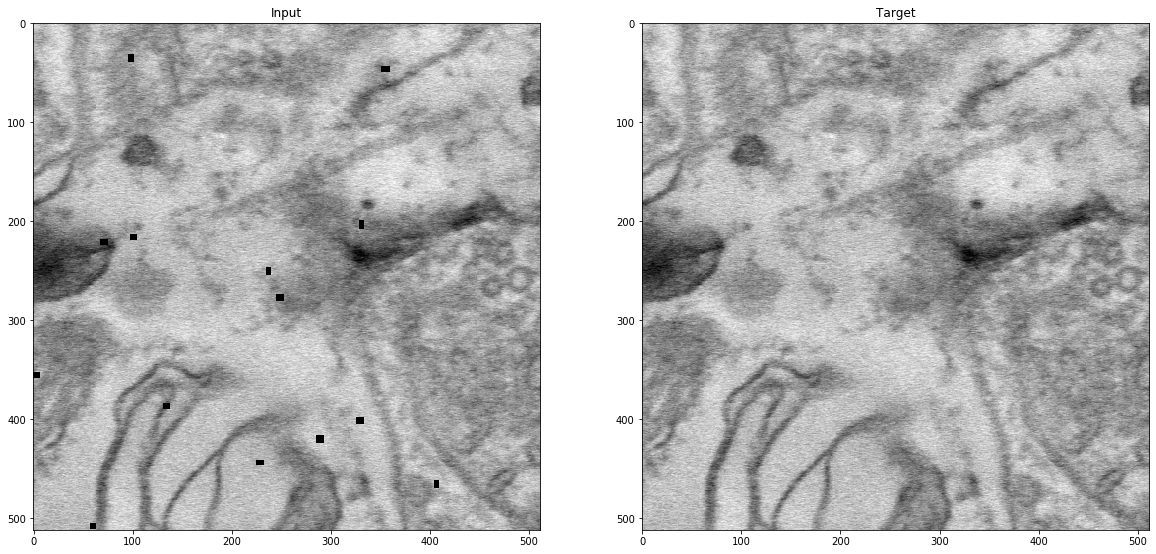

In [27]:
show_sample(inpaint_dataset, idx=32000)

In [9]:
x, y = train_ds[3000]

In [11]:
model.eval()
model.cuda()
pred = model(x.unsqueeze(0).cuda())

In [22]:
pred.mean()

tensor(0.4376, device='cuda:2', grad_fn=<MeanBackward0>)

In [23]:
x.mean()

tensor(0.4367)

In [24]:
y.mean()

tensor(0.4378)

In [19]:
def show_result(x, y, pred, figsize=(20,20)):
    """A helper function to visualize data samples."""
    f, axarr = plt.subplots(1,3, figsize=figsize)  # create visualizations
    axarr[0].imshow(x.permute(1,2,0)) # visualize image tensor
    axarr[0].set_title('Input')
    axarr[1].imshow(y.permute(1,2,0).squeeze(), cmap=plt.cm.gray) # visualize image tensor
    axarr[1].set_title('Target')
    axarr[2].imshow(pred.squeeze(), cmap=plt.cm.gray) # visualize image tensor
    axarr[2].set_title('Prediction')

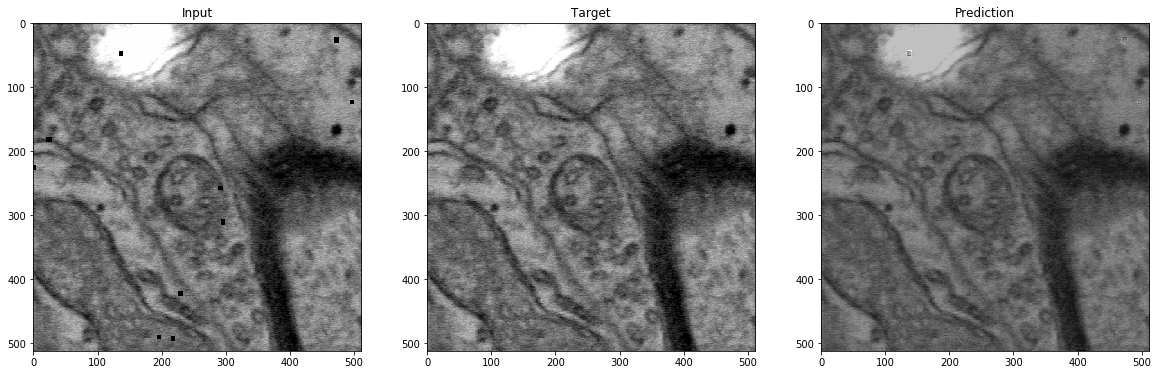

In [20]:
show_result(x, y, pred)